In [16]:
import pandas as pd
import pandas_datareader as wb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [17]:
aapl=wb.DataReader('AAPL',data_source='yahoo',start='2010-1-1',end='2020-1-1')

In [19]:
def get_technical_indicators(dataset):
    dataset.sort_index(inplace=True)
    features=pd.DataFrame(index=dataset.index)
    features['ma7']=dataset['Adj Close'].rolling(window=7).mean()
    features['ma21']=dataset['Adj Close'].rolling(window=21).mean()
    #create macd
    features['26ema']=dataset['Adj Close'].ewm(span=26).mean()
    features['12ema']=dataset['Adj Close'].ewm(span=12).mean()
    features['MACD']=(features['12ema']-features['26ema'])
    #create Bollinger band
    features['20sd']=dataset['Adj Close'].rolling(20).std()
    features['upperband']=features['ma21']+(features['20sd']*2)
    features['lowerband']=features['ma21']-(features['20sd']*2)
    
    #create ema
    features['ema']=dataset['Adj Close'].ewm(span=20).mean()
    
    #ROC
    N=dataset['Adj Close'].diff(10)
    D=dataset['Adj Close'].shift(10)
    features['ROC']=N/D
    
    #CCI
    TP=(dataset['High']+dataset['Low']+dataset['Adj Close'])/3
    features['CCI']=(TP-TP.rolling(20).mean())/(0.015*TP.rolling(20).std())
    
    #ATR
    features['TR']=dataset['High']-dataset['Low']
    features['ATR']=features['TR'].ewm(span=10).mean()
    
    return features

features=get_technical_indicators(aapl)

In [20]:
vars_=features[['MACD','20sd','TR','ma21','ROC','CCI']]

In [21]:
jet=plt.get_cmap('jet')
colors=iter(jet(np.linspace(0,1,10)))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

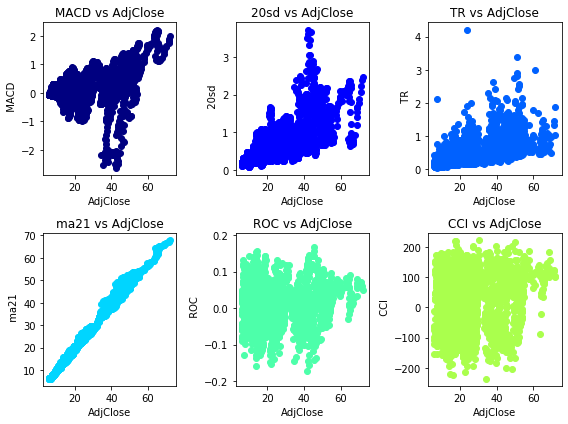

In [23]:
def correlation(df,features,variables,n_rows,n_cols):
    fig=plt.figure(figsize=(8,6))
    for i,var in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        asset=features.loc[:,var]
        ax.scatter(df['Adj Close'],asset,c=next(colors))
        ax.set_xlabel('AdjClose')
        ax.set_ylabel("  {}".format(var))
        ax.set_title(var+" vs AdjClose")
    fig.tight_layout()
    plt.show()
    
columns=vars_.columns
correlation(aapl,vars_,columns,2,3)
    

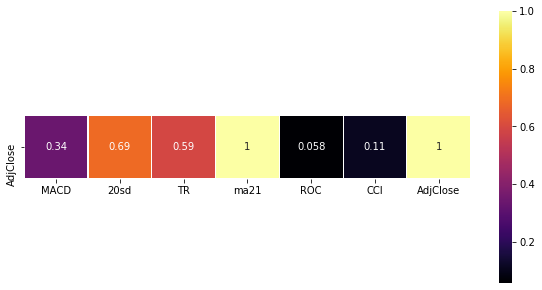

In [26]:
df=vars_.copy()
df['AdjClose']=aapl['Adj Close']

colormap=plt.cm.inferno
plt.figure(figsize=(10,5))
corr=df.corr()
sns.heatmap(corr[corr.index=='AdjClose'],linewidths=0.1,vmax=1.0,square=True,cmap=colormap,linecolor='white',annot=True);
plt.show()

In [27]:
prices=pd.DataFrame(aapl['Adj Close'])
vars_model=prices.join(vars_)
vars_model=vars_model.dropna()

In [29]:
X=vars_model[['MACD','20sd','TR','ROC','CCI']].values
y=vars_model['Adj Close'].values

In [31]:
forest=RandomForestRegressor(n_estimators=1000)
forest=forest.fit(X,y)
importances=forest.feature_importances_

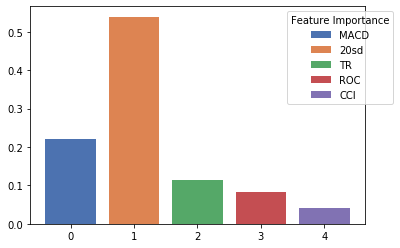

In [33]:
values=list(zip(vars_model.columns[1:],importances))
headers=['feature','score']
values_df=pd.DataFrame(values,columns=headers)

#plot feature Importance
columns=['MACD','20sd','TR','ROC','CCI']
nd=np.arange(len(columns))
width=0.5
fig=plt.bar(nd,values_df['score'].values,color=sns.color_palette("deep",5))
plt.legend(fig,columns,loc='upper right',bbox_to_anchor=(1.1,1),title="Feature Importance")
plt.show()